# ltu-ili jupyter interface
This is a tutorial for using the ltu-ili inference framework in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Device: cpu


## Toy NPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

In [2]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

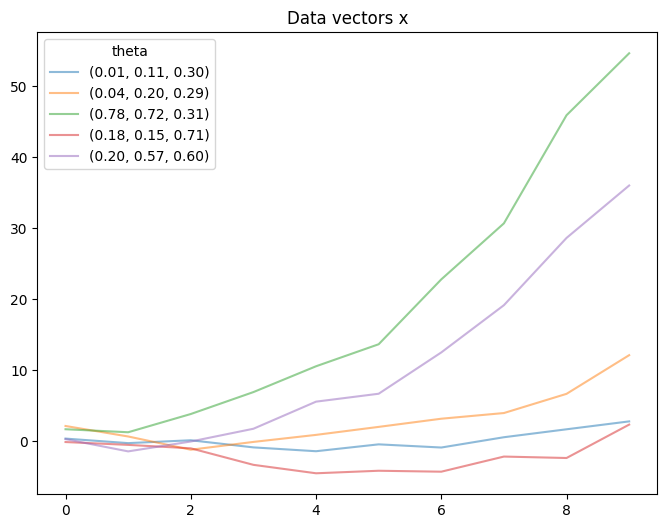

In [3]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The SBIRunner object will handle all of the data normalization and model training for us. We just need to provide it with:
- our parameter prior
- our inference type (SNPE/SNLE/SNRE)
- our desired neural network architecture
- our training hyperparameters

On the backend, it does a validation split among the provided training data, trains the neural networks with an Adam optimizer, and enforces an early stopping criterion to prevent overfitting. All the parameters of these processes can be independently configured.

In [4]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
repeats_maf = 2 # not to have to duplicate code for a large ensemble of identical architectures
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5, repeats = repeats_maf),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [5]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Neural network successfully converged after 236 epochs.

INFO:root:Training model 2 / 3.


 Neural network successfully converged after 297 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 340

INFO:root:It took 19.287612915039062 seconds to train models.


 Neural network successfully converged after 347 epochs.

Here, the output of the runner is a posterior model and a log of training statistics. The posterior model is a [NeuralPosteriorEnsemble](https://github.com/mackelab/sbi/blob/6c4fa7a6fd254d48d0c18640c832f2d80ab2257a/sbi/utils/posterior_ensemble.py#L19) model and automatically combines samples and probability densities from its component networks.

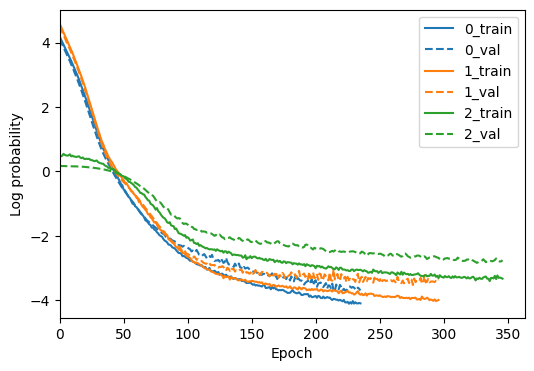

In [6]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_loss'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_loss'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

We now can take the posterior model learned by the InferenceRunner and use it to make predictions on new data. First, we consider generating samples from a posterior conditioned on a single observation.

In [7]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 214 posterior samples:   0%|          | 0/214 [00:00<?, ?it/s]

Drawing 271 posterior samples:   0%|          | 0/271 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

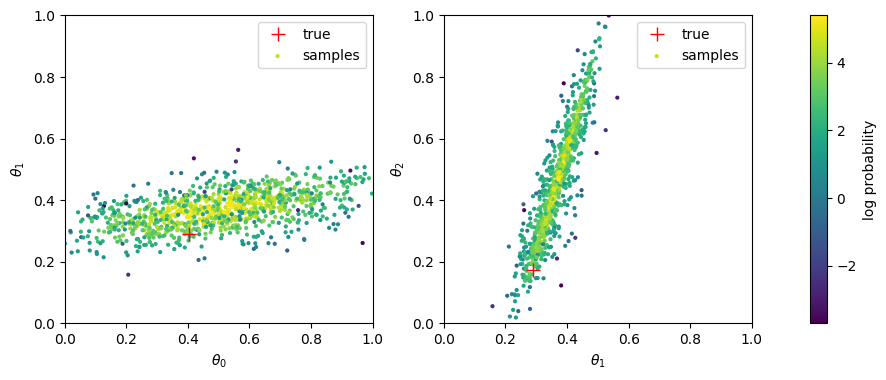

In [8]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

<class 'sbi.inference.posteriors.ensemble_posterior.EnsemblePosterior'>


Drawing 203 posterior samples:   0%|          | 0/203 [00:00<?, ?it/s]

Drawing 263 posterior samples:   0%|          | 0/263 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

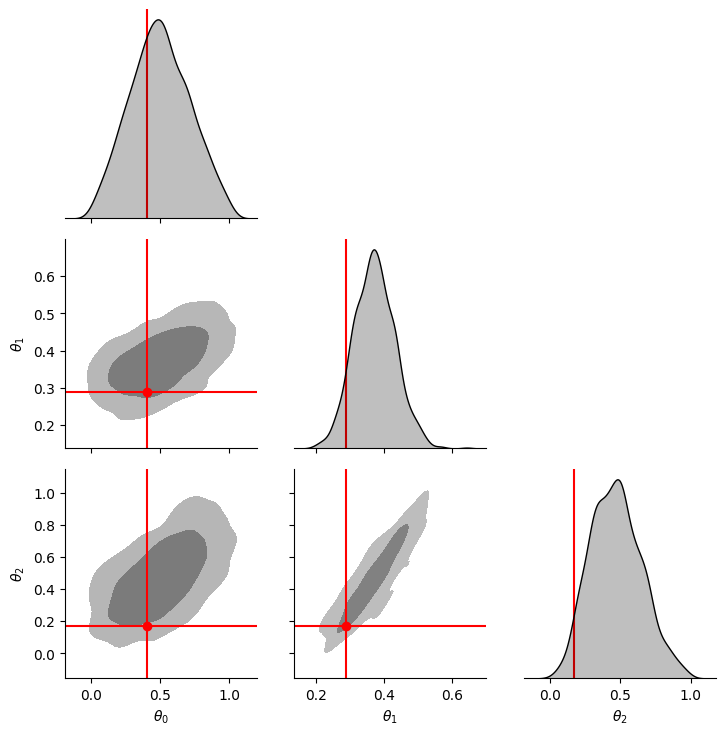

In [9]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

The above plot shows the 68% and 95% confidence intervals of our ensemble posterior prediction. This shows that our model posterior is consistent with the true parameters for one datum. **However, how do we know that our model is good at predicting the full dataset?**


We can use the `PosteriorCoverage` object to measure various statistics about the posterior's performance on the whole dataset. Below, we ask `PosteriorCoverage` to compute:
 - `"coverage"`: the marginal, empirical coverage (P-P plot) of the model posteriors
 - `"histogram"`: the histogram of posterior ranks
 - `"predictions"`: classic true vs. predictions plots for all data points, with error bars
 - `"tarp"`: the multivariate, empirical coverage (P-P plot) of the model posteriors
 - `"logprob"`: the log probability of the true data under the model posterior

For explicit details on the definition and constructions of these plots, see Section 2.4 of [the LtU-ILI paper](https://arxiv.org/abs/2402.05137). The results of these metrics are shown, consecutively, in the output plots.

<class 'sbi.inference.posteriors.ensemble_posterior.EnsemblePosterior'>



INFO:root:Mean logprob: 3.7686e+00Median logprob: 3.8356e+00

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
100/100 [00:00<00:00, 133.23it/s]

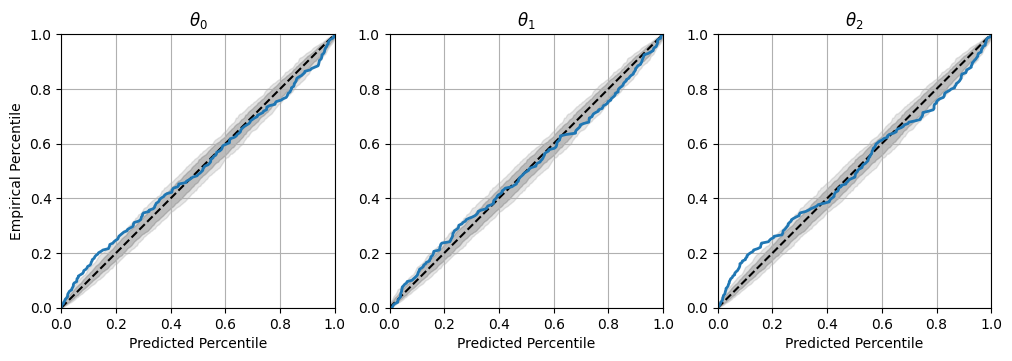

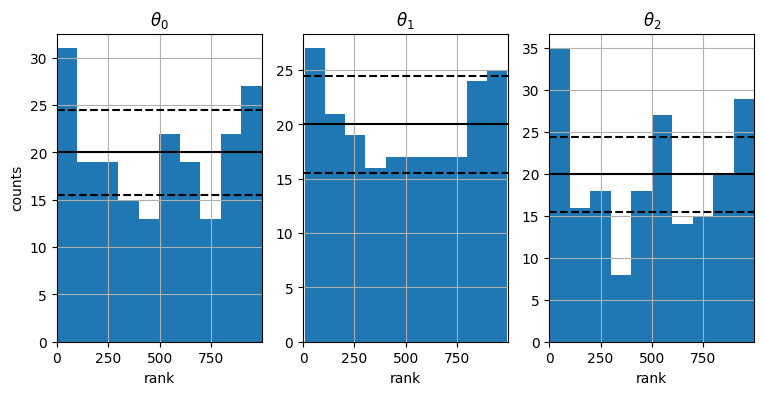

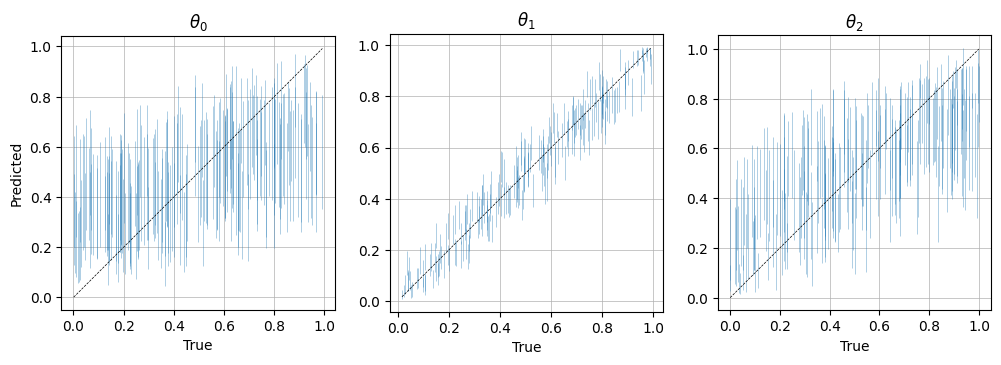

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


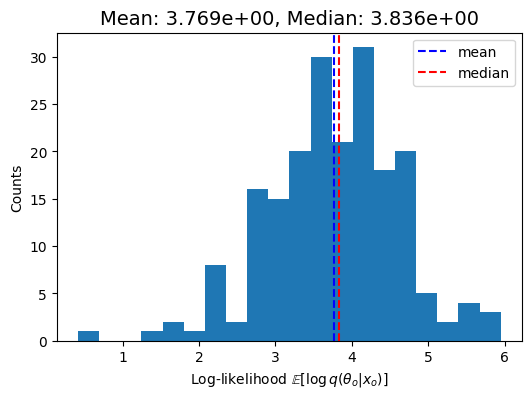

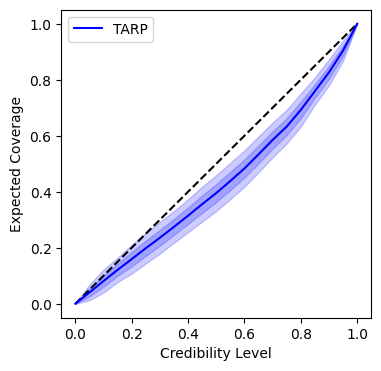

In [11]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

In the ensemble model, it looks like our posteriors are well-calibrated when evaluated on marginal distributions, but slightly negatively biased in the multivariate TARP coverage.

Instead of computing validation metrics on the entire ensemble, we can examine the properties of the individual component networks. This allows us to diagnose problems with individual training runs.

We first look at the predictions from each component posterior for a single data point. The following plot uses `PlotSinglePosterior` to overplot contours for the same prediction by different models.

<class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

<class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

<class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

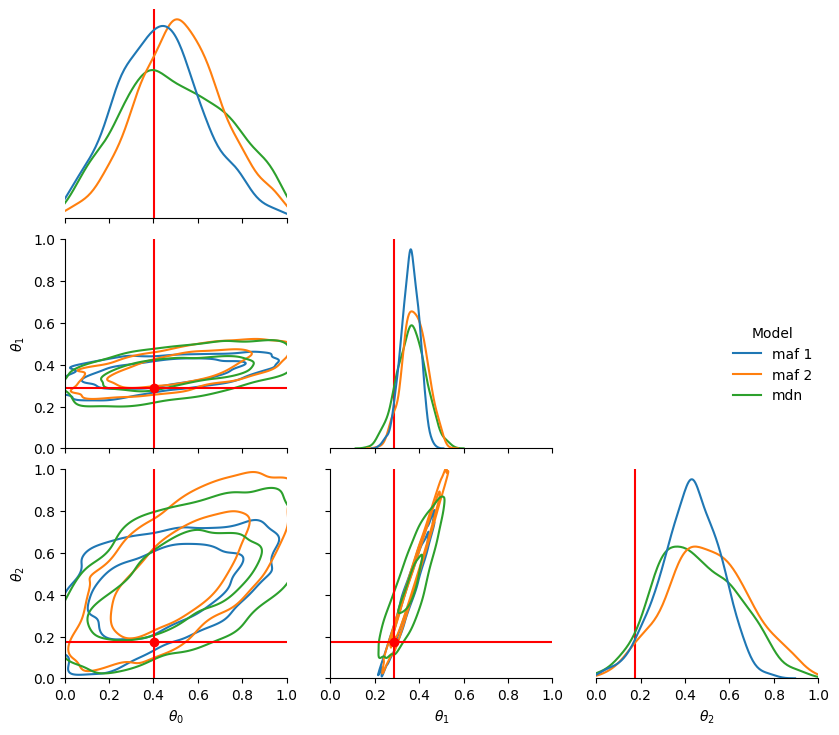

In [13]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x[ind], theta_fid=theta[ind],
    name='maf 1',
    lower=np.zeros(3), upper=np.ones(3)
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x[ind], theta_fid=theta[ind],
    name='maf 2',
    lower=np.zeros(3), upper=np.ones(3),
    grid = fig
)

# overplot the posterior for model #3 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[2],
    x_obs = x[ind], theta_fid=theta[ind],
    name='mdn',
    lower=np.zeros(3), upper=np.ones(3),
    grid=fig  # overplot on the same figure
)

It looks like `mdn` models struggle to capture the strong degeneracies between $\theta_1$ and $\theta_2$, suggesting it is insufficiently flexible.

We can now compute separately `PosteriorCoverage` for each posterior in the ensemble.

<class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>




00%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 136.09it/s]

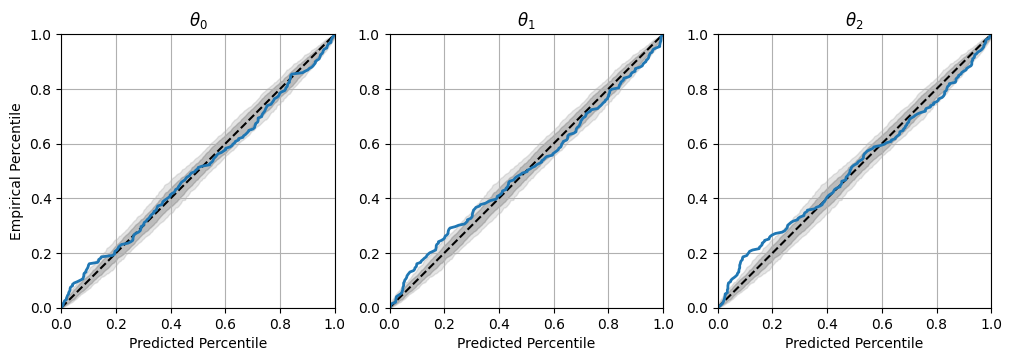

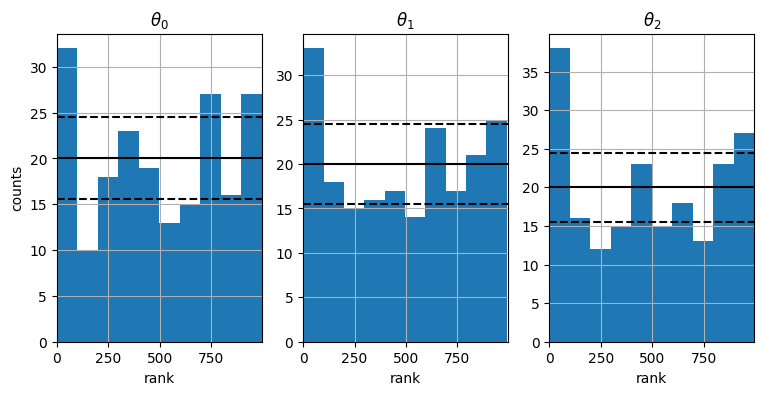

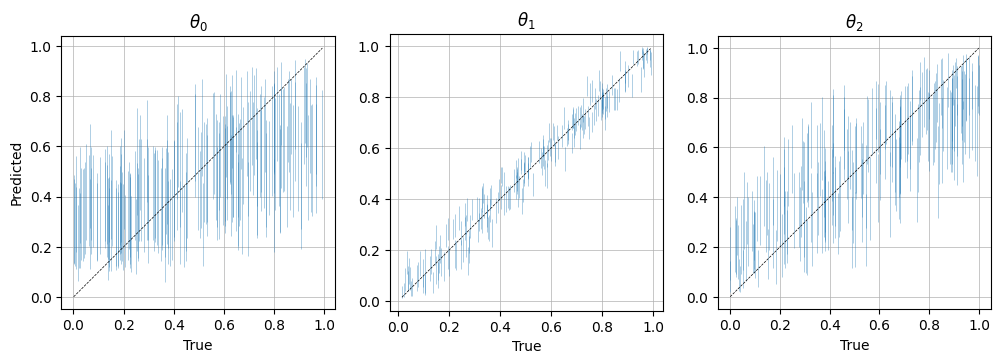

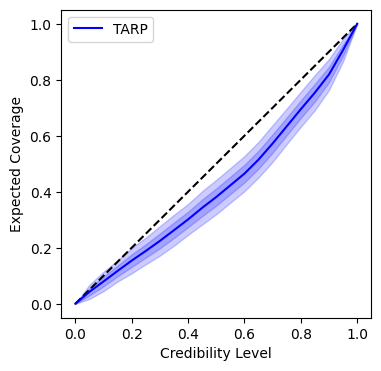

In [14]:
# Drawing samples for each posterior in the ensemble
# First the first MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x=x, theta=theta
)

<class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>




00%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.40it/s]

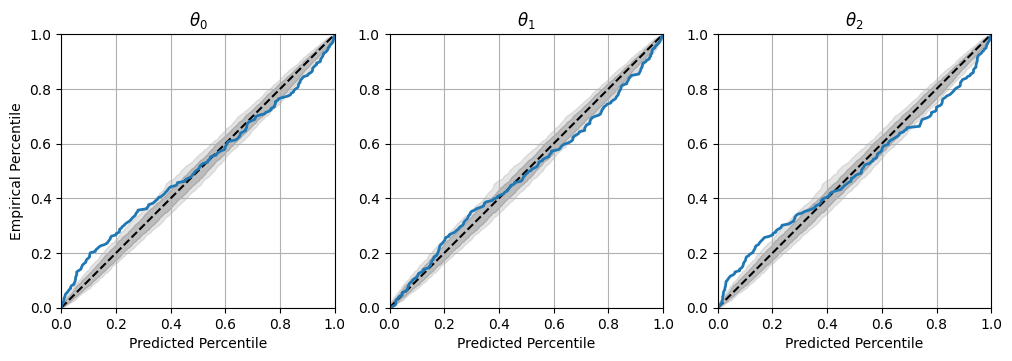

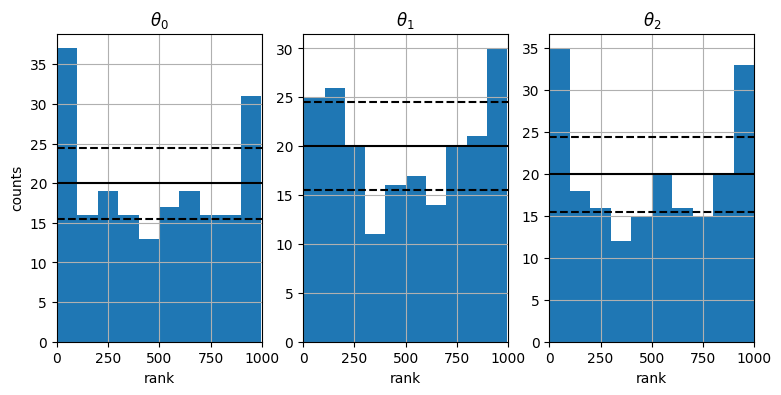

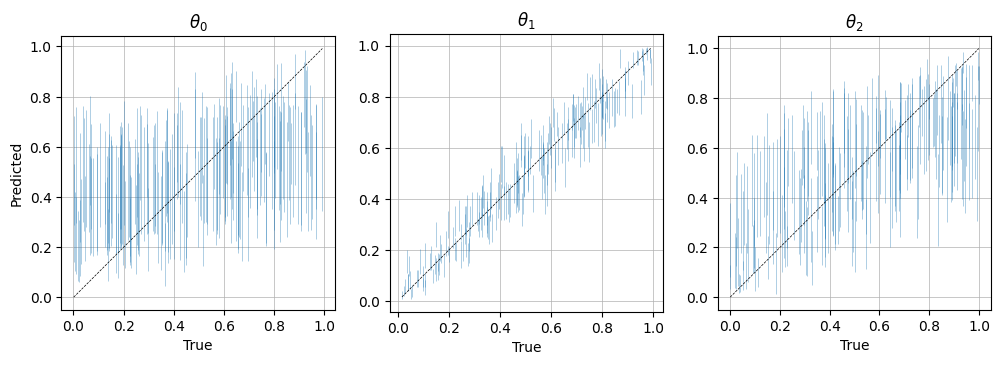

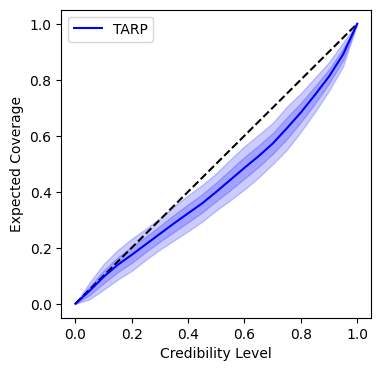

In [15]:
# Then for the MDN
fig = metric(
    posterior=posterior_ensemble.posteriors[2],
    x=x, theta=theta
)

From these results, we see that we are largely consistent and calibrated in the univariate coverage, with some slight negative bias shown in the multivariate coverage. It looks like the MAF model has slightly better constraints than the MDN model, while retaining the same calibration.

## Toy NLE
This example uses the same dataset as the previous SNPE example, but uses a likelihood estimation model instead of an amortized posterior estimation.

In [14]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 4321
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

In [15]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NLE', model='made', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [16]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 625

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 410632 epochs.

INFO:root:It took 29.21533489227295 seconds to train models.


 Neural network successfully converged after 414 epochs.

 Neural network successfully converged after 721 epochs.Training model 2 / 2.
 Neural network successfully converged after 421 epochs.It took 29.513384342193604 seconds to train models.


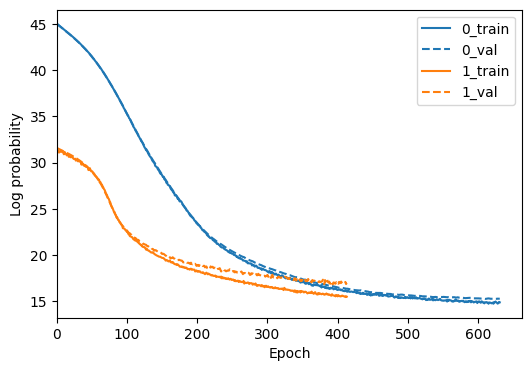

In [17]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_loss'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_loss'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [18]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind], 
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples, 
    x[ind]
).detach().cpu().numpy()

Running vectorized MCMC with 6 chains:   0%|          | 0/1674 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/2328 [00:00<?, ?it/s]

Note: Amortized liklihood estimators do not directly estimate the posterior, but instead build a model for the relative likelihood. This can be combined with a prior to estimate the potential function, which is proportional to the log_probability up to a normalizing constant. Hence, we use MCMC sampling for SNLE models to probe the posterior distribution.

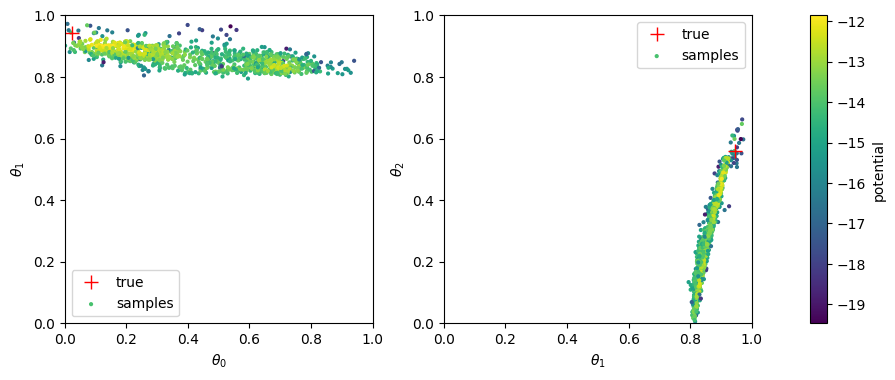

In [19]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

<class 'sbi.inference.posteriors.ensemble_posterior.EnsemblePosterior'>




00%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 135.61it/s]

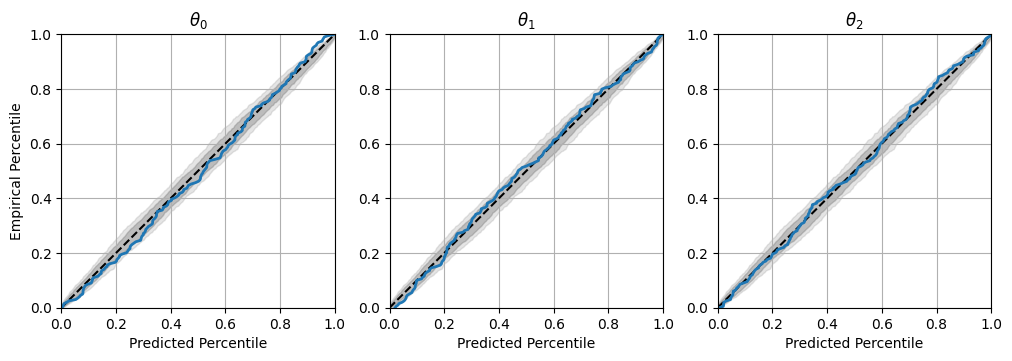

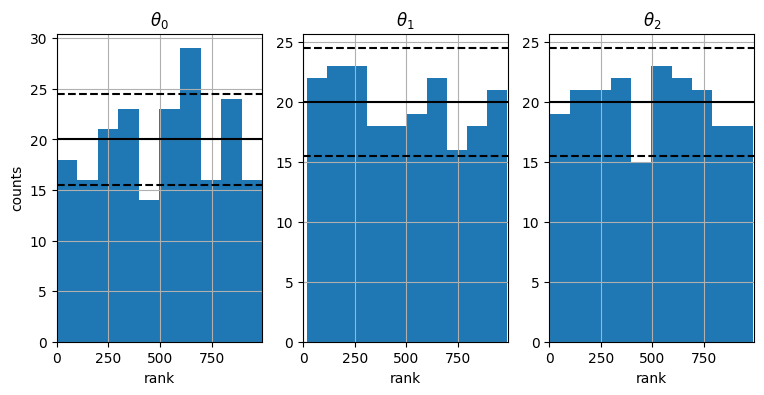

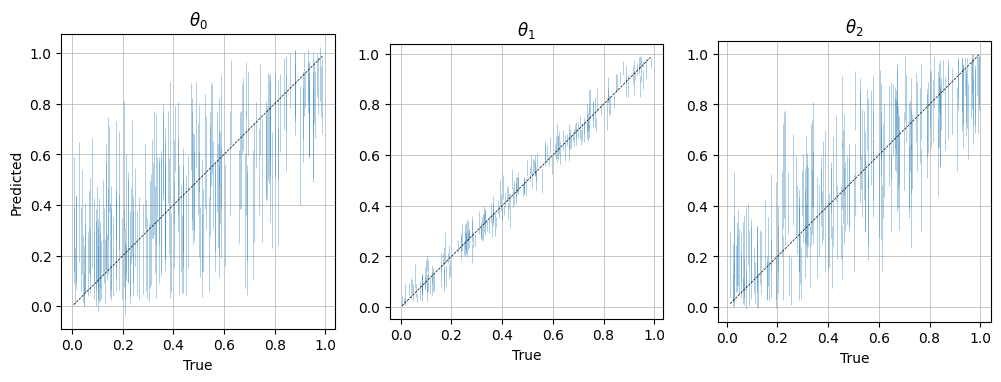

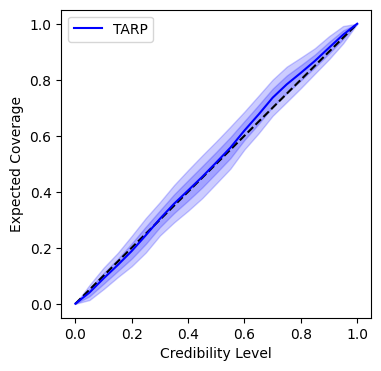

In [20]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='vi',
    sample_params={'dist': 'maf', 'n_particles': 32, 'learning_rate': 1e-2},
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"]
)

# Drawing samples from the ensemble posterior
fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

Looks like we're well-calibrated in both univariate and multivariate tests, with much tighter constraints on $\theta_1$ than the SNPE!

## CAMELS CMD 2D NPE
The real utility of ltu-ili is in its flexibility for applicaiton to a wide variety of real datasets. Through the use of customizable embedding networks, this framework can be extended to handle e.g. image, point cloud, or time-series inputs.

In this example, our inputs are 2D slices of the gas temperature of the simulations in the [CAMELS Multifield Dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/) and our target parameters are 6 cosmological and astrophysical parameters (Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2) that were used to run the simulation. This inference pipeline follows the procedure of the [CAMELS 2D Inference colab example](https://colab.research.google.com/drive/1-BmkA8JSc36O8g9pj7FenD1YSLKqjQR3?usp=sharing).

In [2]:
# Download CAMELS 2D maps and latin hypercube parameters (~3.2 GB)
import os
os.makedirs('./toy', exist_ok=True)
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3750M  100 3750M    0     0  9226k      0  0:06:56  0:06:56 --:--:-- 9305k0:07:07  0:00:32  0:06:35 9363k17k      0  0:06:56  0:00:45  0:06:11 8865k  0  8759k      0  0:07:18  0:00:53  0:06:25 6745k23  0:00:56  0:06:27 6389k56 10.4M  0  9043k      0  0:07:04  0:01:55  0:05:09 6565k0  0:07:03  0:02:27  0:04:36 7400k:41  0:04:28 6430k:55 8002kk      0  0:07:08  0:03:17  0:03:51 9487k  0:03:20  0:03:49 9376k981k      0  0:07:07  0:03:36  0:03:31  9.8M    0     0  9032k      0  0:07:05  0:03:42  0:03:23 11.1M0     0  9012k      0  0:07:06  0:03:43  0:03:23  9.8M0:03:47  0:03:19 7266k0  0:07:07  0:03:49  0:03:18 7968k 0  8972k      0  0:07:07  0:03:57  0:03:10 7850k 0  0:07:08  0:04:04  0:03:04 9189k   0     0  8964k      0  0:07:08  0:04:22  0:02:46 8395k    0  0:07:08  0:04:31  0:02:37 6839k    0  0:07:11  0:04:43  0:02:28 8871k 

In [5]:
# load data
x = np.log10(np.load('./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy'))
theta = np.loadtxt('./toy/params_LH_IllustrisTNG.txt')
theta = np.repeat(theta, 15, axis=0)

# subsample (for speed)
x = x[::2]
theta = theta[::2]

# conform images to pytorch expected shape
x = x[:,None,...]

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)

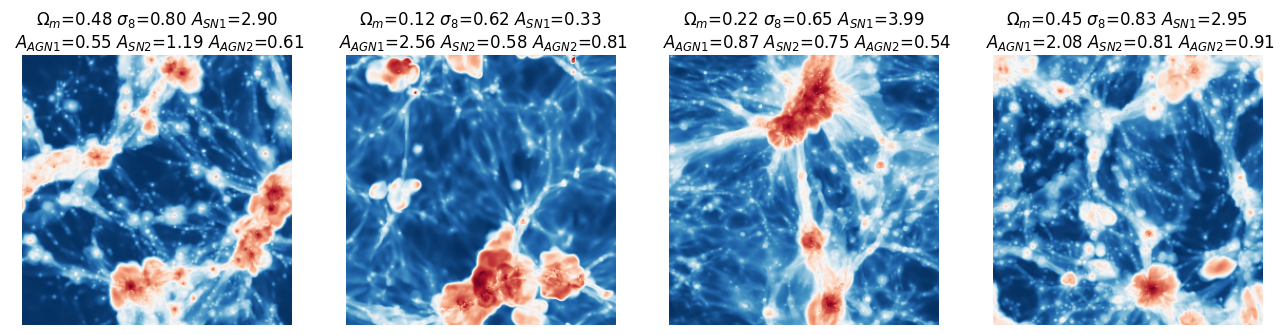

In [6]:
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$',
          r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

# plot a few examples of the data
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ind = np.random.randint(len(x))
    im = axs[i].imshow(x[ind,0], cmap='RdBu_r')

    title = [f'{labels[j]}={theta[ind,j]:.2f}' for j in range(6)]
    title.insert(3, '\n')
    axs[i].set_title(' '.join(title))
    axs[i].axis('off')

In [6]:
# let's build a convolutional embedding network for processing images

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=prior_min, high=prior_max, device=device)

# instantiate a CNN embedding network
embedding_net = ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6,
                           embedding_net=embedding_net)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [8]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 395 epochs.

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 211 epochs.

INFO:root:It took 1416.1765286922455 seconds to train models.


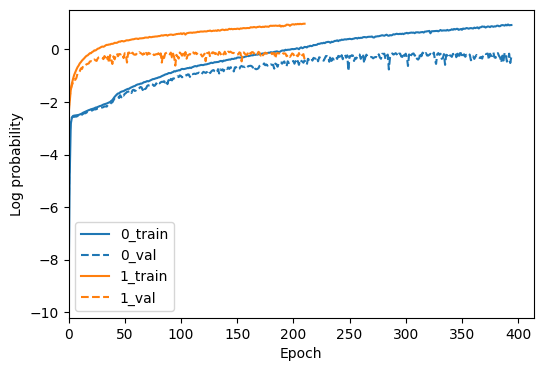

In [9]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [10]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((1000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

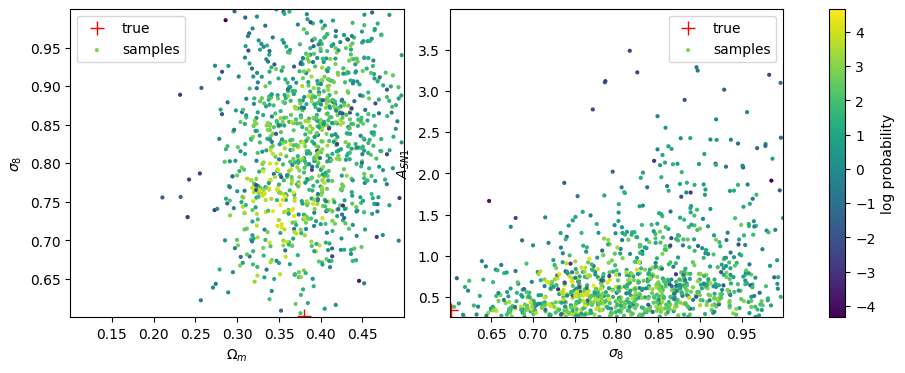

In [11]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_xlim(prior_min[i], prior_max[i])
    axs[i].set_ylim(prior_min[i+1], prior_max[i+1])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i+1])
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

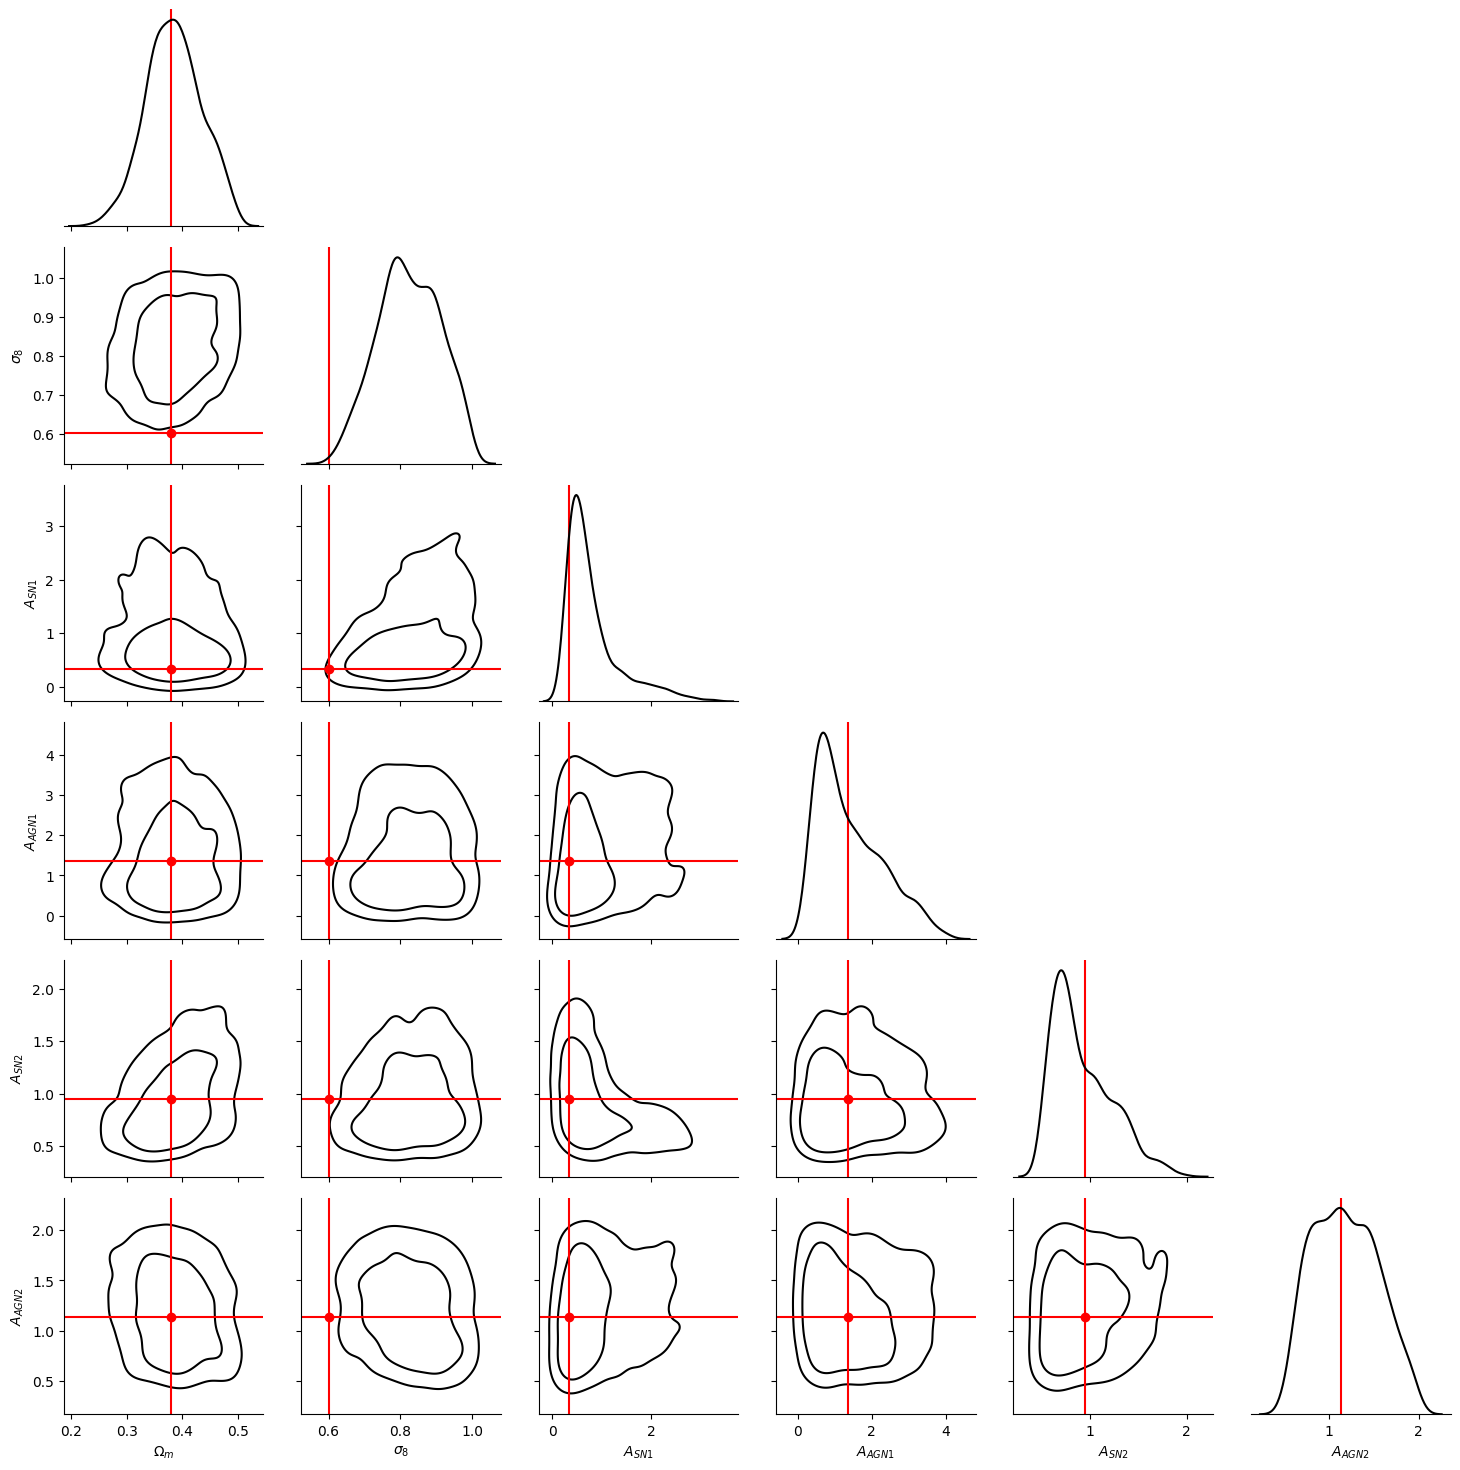

In [12]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=labels, out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
)

100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


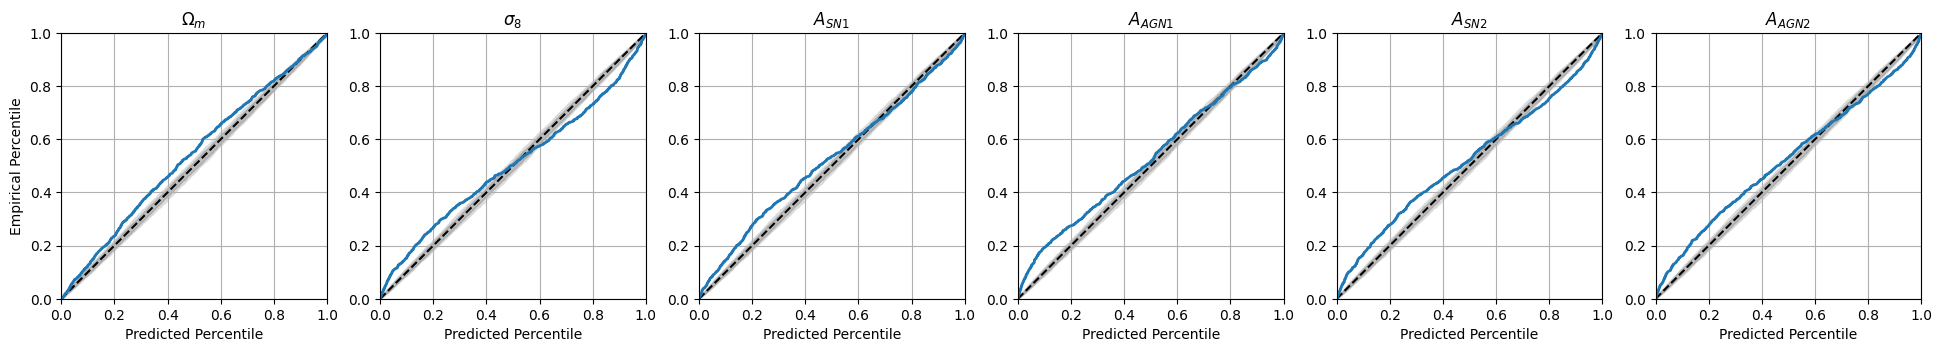

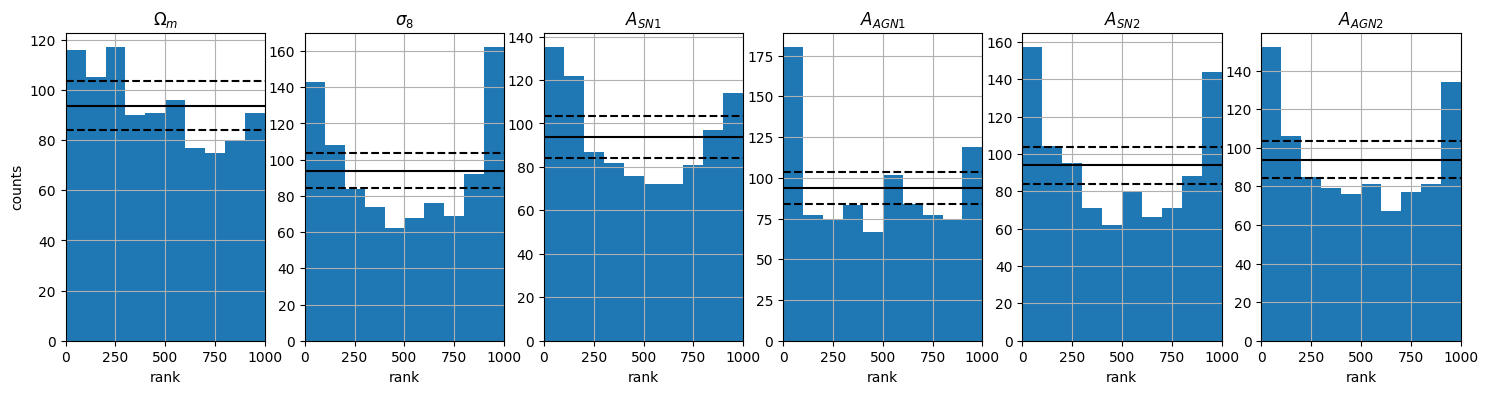

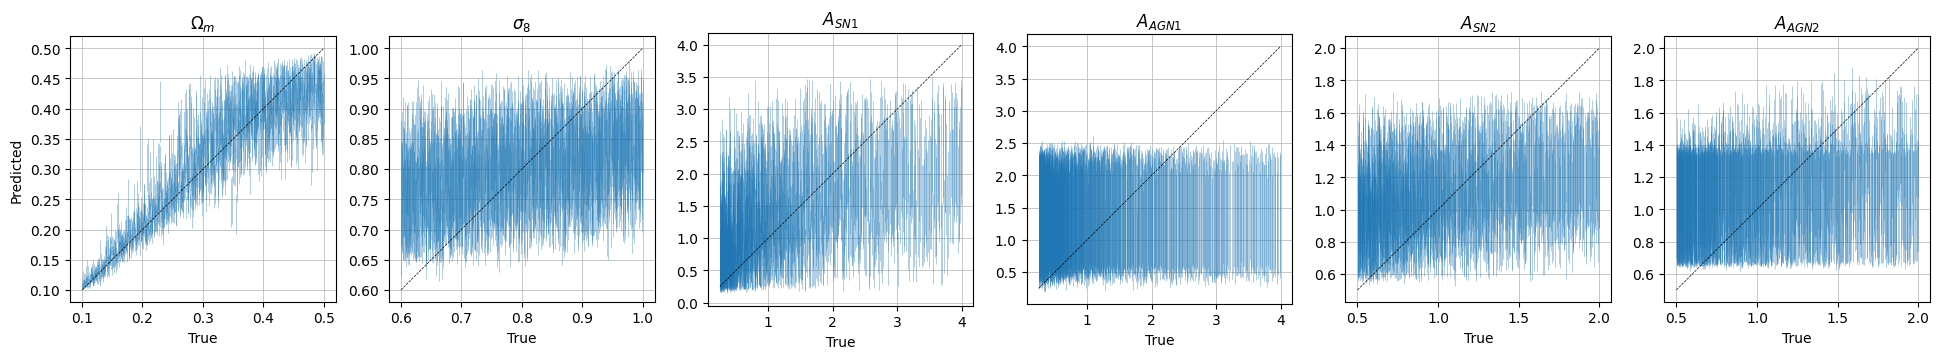

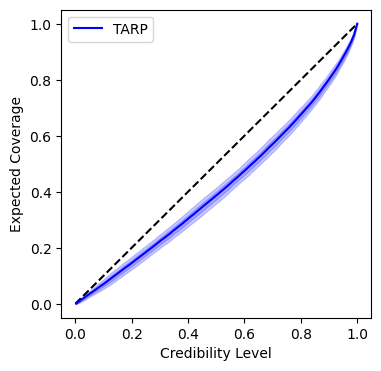

In [13]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=posterior_ensemble,
    x=x[::8], theta=theta[::8]
)

As you can see, we are picking up on clear information on $\Omega_m$ and some on $\sigma_8$ and $A_\mathrm{SN1}$, but not much on the other parameters. This mimics the finding of the CAMELS CMD example, albeit with worse constraints (likely since we have not optimized our CNN architecture). We can see that in the parameters which we can constrain well, we are fairly well-calibrated, but on the whole our posteriors are slightly negatively biased. This is likely the result of the limited prior range, which is cutting off the tails of the posterior for the unconstrained variables.

Nonetheless, this demonstrates how the ltu-ili framework can be used to perform inference on real datasets using customizable embedding networks.